In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

import glob
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import IPython

from pymo.parsers import BVHParser
from pymo.data import Joint, MocapData
from pymo.preprocessing import *
from pymo.viz_tools import *
from pymo.writers import *

import joblib as jl



In [4]:
def extract_joint_angles(bvh_dir, files, destpath, fps):
    
    if not os.path.exists(destpath):
         os.mkdir(destpath)
    
    p = BVHParser()

    data_all = list()
    for f in files:
        ff = os.path.join(bvh_dir, f + '.bvh')
        print(ff)
        data_all.append(p.parse(ff))

    data_pipe = Pipeline([
       ('dwnsampl', DownSampler(tgt_fps=fps,  keep_all=False)),
       ('root', RootTransformer('hip_centric')),
       ('mir', Mirror(axis='X', append=True)),
       ('jtsel', JointSelector(['Spine','Spine1','Spine2','Spine3','Neck','Neck1','Head','RightShoulder', 'RightArm', 'RightForeArm', 'RightHand', 'LeftShoulder', 'LeftArm', 'LeftForeArm', 'LeftHand'], include_root=True)),
       ('exp', MocapParameterizer('expmap')), 
       ('cnst', ConstantsRemover()),
       ('np', Numpyfier())
    ])

    out_data = data_pipe.fit_transform(data_all)
    
    # the datapipe will append the mirrored files to the end
    assert len(out_data) == 2*len(files)
    
    jl.dump(data_pipe, os.path.join(destpath, 'data_pipe.sav'))
        
    fi=0
    for f in files:
        ff = os.path.join(destpath, f)
        print(ff)
        np.savez(ff + ".npz", clips=out_data[fi])
        np.savez(ff + "_mirrored.npz", clips=out_data[len(files)+fi])
        fi=fi+1


In [5]:
# r=root, d=directories, f = files
dest_dir = './processed'
bvh_dir = './data'

# list all bvh files in the bvh_dir
files = []
for r, d, f in os.walk(bvh_dir):
    for file in f:
        print(file)
        if '.bvh' in file:
            ff=os.path.join(r, file)
            basename = os.path.splitext(os.path.basename(ff))[0]
            files.append(basename)
        
# process to destpath
extract_joint_angles(bvh_dir, files, dest_dir, fps=20)


AV_8Walk_Meredith_HVHA_Rep1.bvh
./data\AV_8Walk_Meredith_HVHA_Rep1.bvh
downsampling with rate: 6
RootTransformer
Mirror: X
JointSelector
MocapParameterizer: expmap
Numpyfier
./processed\AV_8Walk_Meredith_HVHA_Rep1


./processed\AV_8Walk_Meredith_HVHA_Rep1.npz
./processed\AV_8Walk_Meredith_HVHA_Rep1_mirrored.npz
./processed\AV_8Walk_Meredith_HVHA_Rep1.npz
./processed\AV_8Walk_Meredith_HVHA_Rep1_mirrored.npz
./processed\AV_8Walk_Meredith_HVHA_Rep1.npz
./processed\AV_8Walk_Meredith_HVHA_Rep1_mirrored.npz
(178, 30)


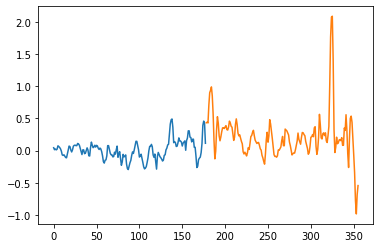

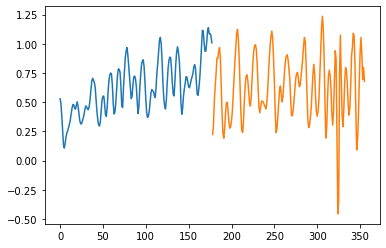

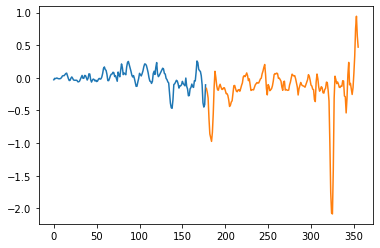

<Figure size 432x288 with 0 Axes>

In [6]:
# Plot features in processed files to check if rotations are continuous
# change joint_idx below to plot different joints
joint_idx = 1

files = []

# r=root, d=directories, f = files
ii=0
for r, d, f in os.walk(dest_dir):
    for file in f:
        if '.npz' in file:
            ff=os.path.join(r, file)
            files.append(ff)
            xxx = np.load(ff)['clips']
            if xxx.shape[0]<80:
                continue
            if ii == 0:
                xall = xxx
            else:
                xall = np.concatenate((xall, xxx), axis=0)
            ii+=1
            
rot_idx = joint_idx*3
for ii in range(3):
    si=0
    for f in files:
        print(f)
        xx = np.load(f)['clips']
        ei = si+xx.shape[0]
        tt = np.arange(si,ei)
        plt.plot(tt,xx[:,rot_idx+ii])
        si=ei        
    plt.figure()
print(xx.shape)
